In [7]:
#|default_exp models.utils

# Model utils

In [8]:
import sys
sys.path.append('..')
from tsai.basics import *

In [9]:
#|export
from mocatml.models.conv_rnn import *
from mocatml.data import *
from fastcore.all import *
from fastai.vision.all import *
from copy import copy

In [10]:
#|export
def stack_density_list_as_preds_targs(l):
    all_preds = [x.to_preds_or_targs() for x in l]
    # Rearrange to get a list of 4 elements, each containing tensors of shape (10, 1, 36, 99)
    final_preds = []
    for seq_idx in range(len(l[0])):  # Assuming each DensitySeq has length 4
        # Collect the seq_idx-th prediction from each DensitySeq and stack them
        stack = torch.stack([preds[seq_idx].squeeze(0) for preds in all_preds], dim=0)
        final_preds.append(stack)
    return final_preds


In [11]:
# test with a list of DensitySeqs
data = np_load_compressed('TLE_density_10_15x15.npy.gz', 
                        path='../example_data')
ds = DensityData(data, lbk=4, h=4, gap=0)
tl = TfmdLists(range(len(ds)), DensityTupleTransform(ds))
l = [y for _,y in tl]
final_preds = stack_density_list_as_preds_targs(l)
test_eq(len(final_preds), 4)
test_eq(final_preds[0].shape, (10, 1, 36, 99))
for i in range(len(ds)):
    test_eq(l[i], DensitySeq.from_preds_or_targs(final_preds, i))
len(final_preds), final_preds[0].shape

(4, torch.Size([10, 1, 36, 99]))

In [37]:
#|export
@patch
@delegates(Learner.get_preds, but=["with_input", "with_loss", "with_decoded"])
def get_preds_iterative(self:Learner, dl, n_iter=1, track_losses=False,
                        with_input=False, **kwargs):
    """
        Call get preds iteratively on a dataloader with a `DensityTupleTransform`
        TODO: Crashes if inner=True (kwargs), so it will produce invisible progress
        bars 
    """
    inp, p, t = self.get_preds(dl=dl, with_input=True, **kwargs)
    ds_copy = copy(dl.ds) # Useful to move the gap without changing the original ds
    if track_losses:
        losses = [self.loss_func(p,t).item()]
    for _ in range(n_iter-1):
        ds_copy.data = ds_copy.data[:,(ds_copy.lbk+ds_copy.gap):] # Move 1 window forward
        tl = TfmdLists(range(len(ds_copy)), DensityTupleTransform(ds_copy))
        # Save the targets before replacing data
        t = stack_density_list_as_preds_targs([y for _,y in tl])
        # Replace the first inputs of the dataset with the predictions
        p_dseqs = [DensitySeq.from_preds_or_targs(p, i, to_array=True) \
                   for i in range(len(p[0]))]
        preds_data = np.stack(p_dseqs).squeeze()
        ds_copy.data[:,:ds_copy.lbk] = preds_data
        dl_new = dl.new(TfmdLists(range(len(ds_copy)), 
                                  DensityTupleTransform(ds_copy)))
        p,_ = self.get_preds(dl=dl_new, with_input=False, **kwargs)
        if track_losses:
            losses.append(self.loss_func(p,t).item())
    res  = [p, t]
    if with_input: res = [inp] + res
    if track_losses: 
        losses = tensor(losses)
        res = res + [losses]
    return tuple(res)

In [36]:
default_device(0)
# TODO: test for gaps 0, pºositive and negative
lbk = 4
h = 4
n_iter= 4
gap = 0
data = np_load_compressed('TLE_density_10_15x15.npy.gz', 
                        path='../example_data')
ds = DensityData(data, lbk=lbk, h=h, gap=gap)
tl = TfmdLists(range(len(ds)), DensityTupleTransform(ds))
dls = tl.dataloaders(bs=32, shuffle=False, num_workers=0)
learn = Learner(dls=dls, 
                model=StackUnstack(SimpleModel()).to(default_device()),
                loss_func=StackLoss())
inp, p,t,losses = learn.get_preds_iterative(dl=dls[0], n_iter=n_iter, 
                                        track_losses=True, with_input=True);
test_eq(len(p), h)
test_eq(p[0].shape, [10, 1, 36, 99])
test_eq(losses.shape[0], n_iter)
assert all_equal(torch.stack(inp, dim=learn.dim).squeeze(0), 
        torch.stack([torch.stack(learn.dls.itemgot()[x][0], dim=0) for x in range(dls[0].n)], dim=0))
# Compare with the direct prediction made with a gap
ds_gap = copy(ds)
ds_gap.gap += (n_iter-1)*h
dl_gap = dls.new(TfmdLists(range(len(ds_gap)), DensityTupleTransform(ds_gap)))
p2,t2 = learn.get_preds(dl=dl_gap)
loss2 = learn.loss_func(p2,t2).item()
test_ne(p, p2)
test_eq(t, t2)

In [14]:
#|export
@patch
def get_individual_losses(self:Learner, p, t):
    """
        Get the loss for each element given predictions and targets computed
        in learn.get_preds
    """
    individual_losses = []
    for i in range(p[0].shape[0]):
        p_element = tuple(p_horizon[i] for p_horizon in p) 
        t_element = tuple(t_horizon[i] for t_horizon in t)
        loss = self.loss_func(p_element, t_element)
        individual_losses.append(loss)
    return tensor(individual_losses)

In [15]:
# test
individual_losses = learn.get_individual_losses(p,t)
test_eq(len(individual_losses), len(ds))
test_close(individual_losses.mean(), learn.loss_func(p,t), eps=1e-2)

In [16]:
#|export
@patch
def predict_at(self:Learner, idx, ds_idx=1, ds=None, with_input=False):
    """
        Predict at a given index on a given dataset, or in the learner's
    """
    ds = self.dls[ds_idx].ds if ds is None else ds
    tl = TfmdLists([idx], DensityTupleTransform(ds))
    dl = self.dls.new(tl)
    if with_input: 
        inp,p,t = self.get_preds(dl=dl, with_input=True, inner=True)
        return inp,p,t
    else:
        p, t = self.get_preds(dl=dl, with_input=False, inner=True)
        return p, t

In [17]:
# Test
p0, t0 = learn.predict_at(0, ds_idx=0)
test_eq(len(p0), h)
test_eq(p0[0].shape, [1, 1, 36, 99])
assert all_equal(torch.stack(t0, dim=learn.dim).squeeze(0),
            torch.stack(learn.dls.itemgot()[0][1], dim=0))

inp0,p0,t0  = learn.predict_at(0, ds_idx=0, with_input=True)
test_eq(len(p0), h)
test_eq(p0[0].shape, [1, 1, 36, 99])
test_eq(t0[0].shape, [1, 1, 36, 99])
test_eq(inp0[0].shape, [1, 1, 36, 99])
assert all_equal(torch.stack(inp0, dim=learn.dim).squeeze(0), 
          torch.stack(learn.dls.itemgot()[0][0], dim=0))
assert all_equal(torch.stack(t0, dim=learn.dim).squeeze(0),
            torch.stack(learn.dls.itemgot()[0][1], dim=0))

In [18]:
#|export
@patch
@delegates(DensitySeq.show, but=["title", "start_epoch"])
def show_preds_at(self:Learner, idx, p=None, t=None, inp=None, with_input=None, 
                  with_targets=False, titles=["Input", "Prediction", "Target"],
                  start_epoch=0, **kwargs):
    """
        Show predictions at a given index
    """
    if t is not None: with_targets=True
    if inp is not None: with_input=True
    if p is None:
        inp, p, t = self.predict_at(idx, with_input=True, **kwargs)
        idx = 0
    if with_input:
        i_seq = DensitySeq.create([inp[i][idx] for i in range(len(inp))])
        i_seq.show(title=titles[0], x_disc=RP_DISC, y_disc=AM_DISC, **kwargs)
    p_seq = DensitySeq.create([p[i][idx] for i in range(len(p))])
    p_seq.show(start_epoch=start_epoch+len(p), title=titles[1], 
               x_disc=RP_DISC, y_disc=AM_DISC, **kwargs)
    if with_targets:
        t_seq = DensitySeq.create([t[i][idx] for i in range(len(t))])
        t_seq.show(start_epoch=start_epoch+len(p), title=titles[2], 
                   x_disc=RP_DISC, y_disc=AM_DISC, **kwargs)

In [40]:
# Test
lbk = 4
h = 4
n_iter= 4
gap = -2
data = np_load_compressed('TLE_density_10_15x15.npy.gz', 
                        path='../example_data')
ds = DensityData(data, lbk=lbk, h=h, gap=gap)
tl = TfmdLists(range(len(ds)), DensityTupleTransform(ds))
dls = tl.dataloaders(bs=32, shuffle=False, num_workers=0)
learn = Learner(dls=dls, 
                model=StackUnstack(SimpleModel()).to(default_device()),
                loss_func=StackLoss())
inps, p,t = learn.get_preds_iterative(dl=dls[0], n_iter=2, with_input=True)

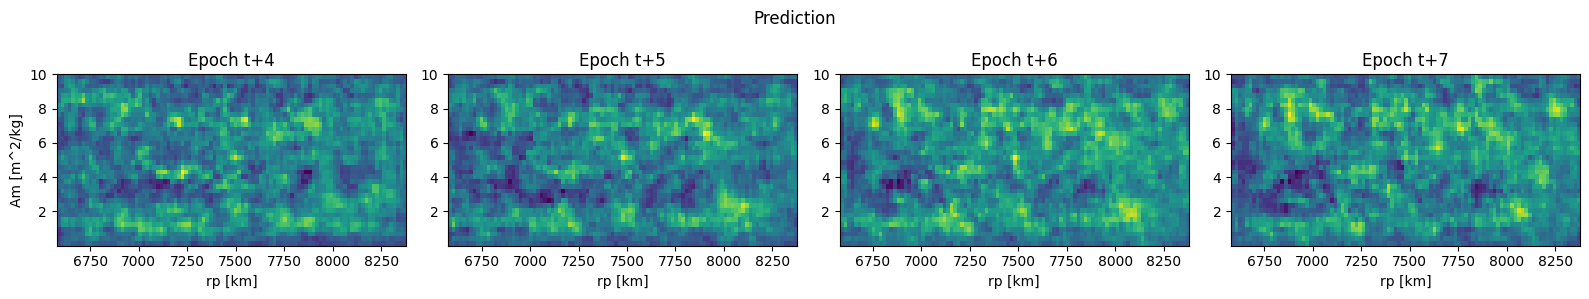

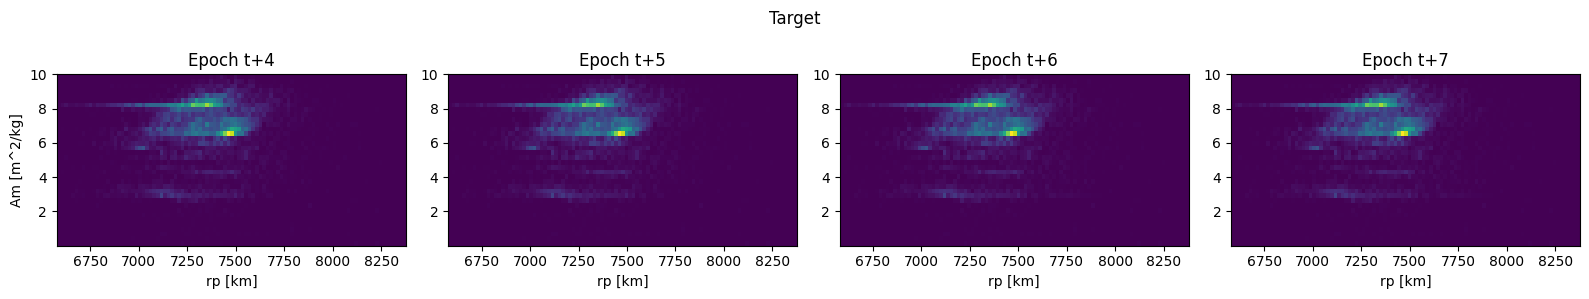

In [41]:
learn.show_preds_at(0, p, t)

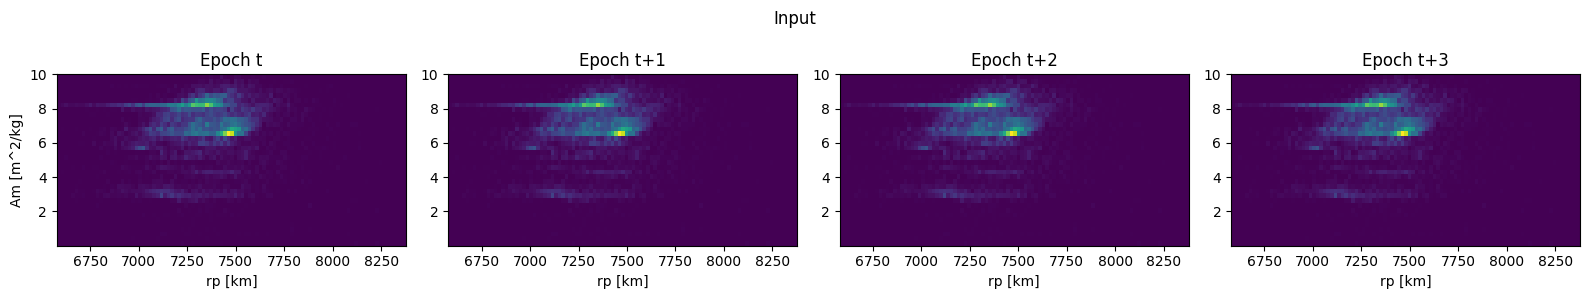

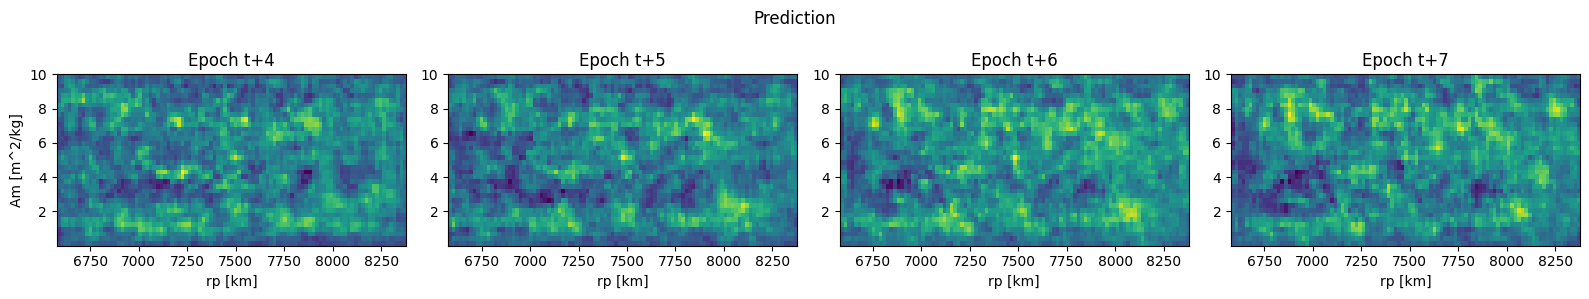

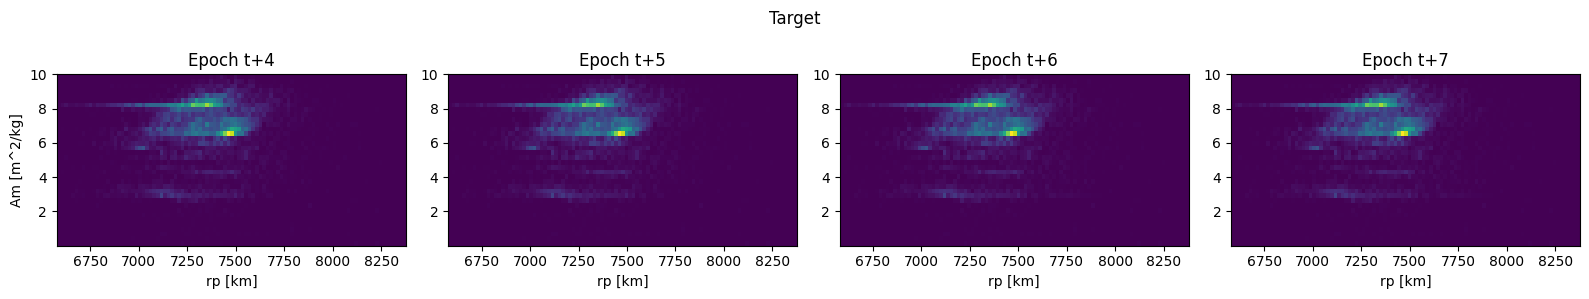

In [42]:
learn.show_preds_at(0, p=p, t=t, inp=inps)